In [109]:
import random
import numpy as np
import pandas as pd
import time
import json
import re
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import AveragePooling1D
from keras.layers.embeddings import Embedding
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [63]:
dt = pd.read_csv('investments.csv')

In [64]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168647 entries, 0 to 168646
Data columns (total 18 columns):
company_permalink          168647 non-null object
company_name               168646 non-null object
company_category_list      165015 non-null object
company_country_code       158126 non-null object
company_state_code         155216 non-null object
company_region             156162 non-null object
company_city               156164 non-null object
investor_permalink         168635 non-null object
investor_name              168635 non-null object
investor_country_code      137708 non-null object
investor_state_code        123908 non-null object
investor_region            125430 non-null object
investor_city              136483 non-null object
funding_round_permalink    168647 non-null object
funding_round_type         168647 non-null object
funding_round_code         81062 non-null object
funded_at                  168647 non-null object
raised_amount_usd          147028 non-nu

In [65]:
dt.head(10)

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,23,Shanghai,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0
1,/organization/004-technologies,004 Technologies,Software,USA,IL,"Springfield, Illinois",Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,5,Frankfurt,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,NaN
2,/organization/01games-technology,01Games Technology,Games,HKG,NaN,Hong Kong,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,NaN,Hong Kong,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,2014-07-01,41250.0
3,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/capital-one,Capital One,USA,VA,"Washington, D.C.",Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0
5,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0
6,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,2013-01-03,1700000.0
7,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,2014-07-19,8900000.0
8,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/paxion-capital-partners,Paxion Capital Partners,NaN,NaN,NaN,NaN,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0
9,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/transamerica,Transamerica,USA,IA,Cedar Rapids,Cedar Rapids,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0


In [66]:
dt = dt[['company_name','company_category_list','company_country_code','company_region',
         'investor_name','investor_permalink','investor_country_code','investor_region']]
#     if not isinstance(row['company_name'], str) or not isinstance(row['investor_name'], str):
#         print(i, 'company:{}'.format(row['company_name']), 'investor:{}'.format(row['investor_name'])

In [67]:
PORTFOLIO_SIZE = 10
MODEL_NAME = 'model_ps_{}'.format(PORTFOLIO_SIZE)

In [69]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168647 entries, 0 to 168646
Data columns (total 8 columns):
company_name             168646 non-null object
company_category_list    165015 non-null object
company_country_code     158126 non-null object
company_region           156162 non-null object
investor_name            168635 non-null object
investor_permalink       168635 non-null object
investor_country_code    137708 non-null object
investor_region          125430 non-null object
dtypes: object(8)
memory usage: 10.3+ MB


In [70]:
# dt['funding_round_type'].describe()

In [71]:
dt = dt.dropna()
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114886 entries, 0 to 168645
Data columns (total 8 columns):
company_name             114886 non-null object
company_category_list    114886 non-null object
company_country_code     114886 non-null object
company_region           114886 non-null object
investor_name            114886 non-null object
investor_permalink       114886 non-null object
investor_country_code    114886 non-null object
investor_region          114886 non-null object
dtypes: object(8)
memory usage: 7.9+ MB


In [118]:
def create_investor_company_dict(dataframe):
    all_companies = set()
    all_investors = set()
    company_investor_dict = {}
    investor_company_dict = {}
    company_info_dict = {} 
    # it should looks like ex: {company_name: {industry_cat: software, country_code: US, region: Bay Area}}
    investor_info_dict = {}
    # it should looks like ex: {investor_name: {country_code: US, region: Bay Area}}

    for i, row in dataframe.iterrows():
        company = row['company_name']
        industry_cat = row['company_category_list']
        comp_cc = row['company_country_code']
        comp_re = row['company_region']

        investor = row['investor_name']
        permalink = row['investor_permalink']
        investor_cc = row['investor_country_code']
        investor_re = row['investor_region']

        regex = re.match(r'/organization', permalink)
        if regex:
            if company not in all_companies:
                company_investor_dict[company] = set()
                company_investor_dict[company].add(investor)
                comp_info = {}
                comp_info['industry_cat'] = industry_cat
                comp_info['country_code'] = comp_cc
                comp_info['region'] = comp_re
                company_info_dict[company] = comp_info
            else:
                company_investor_dict[company].add(investor)

            if investor not in all_investors:
                investor_company_dict[investor] = set()
                investor_company_dict[investor].add(company)
                investor_info = {}
                investor_info['country_code'] = investor_cc
                investor_info['region'] = investor_re
                investor_info_dict[investor] = investor_info
            else:
                investor_company_dict[investor].add(company)

            all_companies.add(company)
            all_investors.add(investor) 
        
    return investor_company_dict, investor_info_dict, company_investor_dict, company_info_dict


In [119]:
investor_company_dict, investor_info_dict, company_investor_dict, company_info_dict = create_investor_company_dict(dt)

In [121]:
len(investor_company_dict)

10057

In [122]:
# select the investors who invested more than 9 startups
investor_portfolio_size = sorted(
    [(k, len(v)) for k, v in investor_company_dict.items() if len(v) >= 10], 
    reverse=True, key=lambda x: x[1])

# investor_portfolio_size

In [123]:
# df = pd.DataFrame(data=investor_portfolio_size, columns=['name', 'number'])
# df['number'].describe()

In [124]:
selected_investors = set([x[0] for x in investor_portfolio_size])

selected_investor_company_dict = {}
for i in selected_investors:
    selected_investor_company_dict[i] = investor_company_dict[i]

In [125]:
selected_companies = set()
for i in selected_investors:
    companies = selected_investor_company_dict[i]
    for c in companies:
        selected_companies.add(c)

selected_companies_id_dict = {}
for i, c in enumerate(selected_companies):
    selected_companies_id_dict[c] = i
        
len(selected_companies)
# selected_companies_id_dict

27855

In [126]:
def create_id_dict(x):
#create a fixed id dictionary
    id_dict = {}
    id_dict_inverse = {}
#     for item in x:
#         if not isinstance(x, str):
#             print(x)
    x = sorted(list(x))
    for i, k in enumerate(x):
        id_dict[k] = i
        id_dict_inverse[i] = k
    return id_dict, id_dict_inverse

In [127]:
#selected_investor_company_dict

In [128]:
selected_investors_id_dict, selected_investors_id_dict_inverse = create_id_dict(selected_investor_company_dict)
selected_companies_id_dict, selected_companies_id_dict_inverse = create_id_dict(selected_companies)   

In [129]:
# selected_investors_id_dict

In [130]:
def create_one_hot_labels(i_c_new_dict, i_id_dict):
    original = i_c_new_dict.keys()
    integer_encoded_labels = [i_id_dict[x] for x in original]
    d = array(integer_encoded_labels)
    print(d)
    labels = to_categorical(d)
    return labels

labels = create_one_hot_labels(selected_investor_company_dict, selected_investors_id_dict)

[ 309 1178 1285 ... 1236 1795  947]


In [131]:
original = selected_investor_company_dict.keys()
integer_encoded_labels = [selected_investors_id_dict[x] for x in original]
d = array(integer_encoded_labels)
labels = to_categorical(d)

In [134]:
# portfolios = list(selected_investor_company_dict.values())
# list(portfolios[0])

In [135]:
# integer encode the investors' portfolios
vocab_size = len(selected_companies)
encoded_portfolios = []
for i in portfolios:
    c_list = list(i)
    encoded_c_list = []
    for c in c_list:
        encoded_c_list.append(selected_companies_id_dict[c])
    
    encoded_portfolios.append(encoded_c_list)    

# encoded_portfolios

In [136]:
# padding the portfolios
df = pd.DataFrame(data=investor_portfolio_size, columns=['name', 'number'])

maxlen = df['number'].max()

padded_portfolios = pad_sequences(encoded_portfolios, maxlen, padding='post')
padded_portfolios

array([[12539,  4119,  4964, ...,     0,     0,     0],
       [13277,  6793,  9689, ...,     0,     0,     0],
       [19432,  7678, 12398, ...,     0,     0,     0],
       ...,
       [15293, 22581,  6253, ...,     0,     0,     0],
       [23170, 26142, 13556, ...,     0,     0,     0],
       [20670, 24167,  2805, ...,     0,     0,     0]], dtype=int32)

In [137]:
maxlen

703

In [138]:
# load json and create model
json_file = open('model_ps_10_gpu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_ps_10_gpu_weights.hdf5")
print("Loaded model from disk")
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# loaded_model.evaluate([dev_desc, dev_kw, norm_dev_data[:, :5]], dev_label, verbose=1)
# loaded_model.predict([dev_desc, dev_kw, norm_dev_data[:, :5]])

Loaded model from disk


In [139]:
investor_embed_mat = model.layers[5].get_weights()[0]
investor_embed_mat = investor_embed_mat.transpose()
# each row represents an investor
np.shape(investor_embed_mat)

(1806, 32)

In [140]:
n_rows = len(investor_embed_mat[:,0])
n_rows

1806

In [141]:
investor_embeddings_dict = {}
# investor_embeddings_dict_inverse = {}
for i in range(n_rows):
    investor_name = selected_investors_id_dict_inverse[i]
    investor_vector = investor_embed_mat[i,:]
    investor_embeddings_dict[investor_name] = investor_vector
    # investor_embeddings_dict_inverse[investor_vector] = investor_name

In [142]:
len(investor_embeddings_dict)

1806

In [143]:
investor_embed_mat[3]

array([-0.11870843, -0.28070146, -1.6547846 ,  0.17978776,  0.20674098,
        1.1029868 ,  0.28246233,  0.19708245,  0.24142307,  1.0215191 ,
       -0.3931798 , -0.10744797,  0.52311754, -0.27014494, -0.11231661,
       -0.03585026, -0.2443429 ,  0.13783054,  0.61563784, -0.09376337,
       -0.08660529,  0.73867434, -0.41204587,  0.21884212,  1.6022635 ,
        0.04249284,  0.8334971 , -0.23594981,  0.13201694, -0.34545726,
        0.34819567, -0.309141  ], dtype=float32)

In [176]:
data = investor_embed_mat
num_clusters= 60
num_components=2

kmeans = KMeans(init='random', n_clusters=num_clusters, n_init=100, algorithm='elkan', 
                random_state=0).fit(data)
kmeans.labels_

array([ 7, 43, 50, ..., 15, 55, 23], dtype=int32)

In [177]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [178]:
def cluster_n_investors(clustNum, selected_investors_id_dict_inverse, selected_investor_company_dict):
    cluster_investors = set()
    cluster_portfolio_companies = set()
    cluster_indices = ClusterIndicesNumpy(clustNum,kmeans.labels_)
    for i in cluster_indices:
        investor = selected_investors_id_dict_inverse[i]
        cluster_investors.add(investor)

        for c in selected_investor_company_dict[investor]:
            cluster_portfolio_companies.add(c)
    
    return cluster_investors, cluster_portfolio_companies

In [179]:
# cluster_dict ={}

# for i in range(num_clusters):
#     investors, portfolio_companies = cluster_n_investors(i, 
#                                                          selected_investors_id_dict_inverse, 
#                                                          selected_investor_company_dict)
    
#     cluster_dict[i] = [investors, portfolio_companies]


In [180]:
def create_clusters_dict(num_clusters):
    cluster_dict ={}
    for i in range(num_clusters):
        investors, portfolio_companies = cluster_n_investors(i, 
                                                             selected_investors_id_dict_inverse, 
                                                             selected_investor_company_dict)
        cluster_dict[i] = [investors, portfolio_companies]
    return cluster_dict

In [181]:
cluster_dict = create_clusters_dict(num_clusters)

In [182]:
investor_embed_mat = model.layers[5].get_weights()[0]
investor_embed_mat = investor_embed_mat.transpose()
norm_investor_embed_mat = investor_embed_mat / np.linalg.norm(investor_embed_mat, axis=1, keepdims=True)

def get_investor_embedding(name):
    return norm_investor_embed_mat[selected_investors_id_dict[name]]

In [183]:
np.shape(norm_investor_embed_mat)

(1806, 32)

In [184]:
def similarity(investor_name):
    embed_probe = get_investor_embedding(investor_name)
    
    similarity_scores = norm_investor_embed_mat.dot(embed_probe)

    closest_ids = np.argpartition(similarity_scores, -5)[-5:]

    closest_ids = closest_ids[np.argsort(similarity_scores[closest_ids])][::-1]

    print(closest_ids)

    for i in closest_ids:
        print('=' * 50)
        investor_name = selected_investors_id_dict_inverse[i]
        print(investor_name, similarity_scores[i])
        print(selected_investor_company_dict[investor_name])

In [185]:
def get_group_mates(investor_name, cluster_dict):
    self_id = selected_investors_id_dict[investor_name]
    km_label = kmeans.labels_[self_id]
    group_mates = cluster_dict[km_label]
    return group_mates

In [186]:
get_group_mates('Y Combinator', cluster_dict)

[{'ATA Ventures',
  'Abingworth',
  'Affinity Capital Management',
  'Alexandria Real Estate Equities',
  'AllianceBernstein',
  'Amasia',
  'Amgen',
  'AngelPad',
  'Anthem Venture Partners',
  'Apax Partners',
  'Applied Ventures',
  'BDCA Venture, Inc.',
  'Base Ventures',
  'CBC Capital',
  'Canyon Creek Capital',
  'Celgene',
  'Clearstone Venture Partners',
  'Delphi Ventures',
  'FundersClub',
  'GBS Ventures',
  'GGV Capital',
  'Global Catalyst Partners',
  'HLM Venture Partners',
  'ITOCHU Corporation',
  'Idea Bulb Ventures',
  'Jerusalem Venture Partners (JVP)',
  'MPM Capital',
  'Medtronic',
  'Melo7 Tech Partners',
  'Mobius Venture Capital',
  'Montage Ventures',
  'Morado Venture Partners',
  'Nokia Growth Partners',
  'Nth Power',
  'Pantera Capital',
  'Pfizer Venture Investments',
  'QueensBridge Venture Partners',
  'SV Life Sciences',
  'Shenzhen Capital Group',
  'Silicon Badia',
  'Sprout Group',
  'Technology Partners',
  'Technology Venture Partners',
  'Third

In [187]:
get_group_mates('StartX', cluster_dict)

[{'Alchemist Accelerator',
  'Alibaba Capital Partners',
  'Alliance of Angels',
  'Aslanoba Capital',
  'BlueRun Ventures',
  'Bpifrance',
  'Crowdcube',
  'DN Capital',
  'Draper Esprit',
  'Draper Fisher Jurvetson (DFJ)',
  'Eleven',
  'Fortify Ventures',
  "Founders' Co-op",
  'High-Tech Gruenderfonds',
  'Idinvest Partners',
  'Intel Capital',
  'Kalaari Capital',
  'Kima Ventures',
  'Pitango Venture Capital',
  'Qualcomm Ventures',
  'Sandbox Industries',
  'Seedcamp',
  'Siemens Venture Capital',
  'StartX',
  'Techstars',
  'U.S. Department of Energy',
  'Wellington Partners'},
 {'Fortumo',
  '3TEN8',
  'Inovus Solar',
  'Implisense',
  'Yunmake',
  'Codementor',
  'Clear2Pay',
  'Compilr',
  'Pulmorphix',
  'Urban Ladder',
  'Tribold',
  'Movable Ink',
  'Mobixell Networks',
  'ZMP',
  'LawDeck',
  'VouchedFor',
  'Sirific Wireless',
  'Wellframe',
  'Roadster',
  'Pilot',
  'BlogCN',
  'Silicon Hive',
  'Prolexic Technologies',
  'Borderfree',
  'PulsePoint',
  'thinkstep',


In [188]:
get_group_mates('500 Startups', cluster_dict)

[{'500 Startups',
  'Allen & Company',
  'Asset Management Ventures (AMV)',
  'Austin Ventures',
  'Canaan Partners',
  'Carmel Ventures',
  'DAG Ventures',
  'DCM',
  'DFJ Growth',
  'DoCoMo Capital',
  'Domain Associates',
  'Easton Capital',
  'Flybridge Capital Partners',
  'Foundation Capital',
  'Foundry Group',
  'Frazier Healthcare Partners',
  'Gold Hill Capital',
  'Google Ventures',
  'Great Oaks Venture Capital',
  'Highland Capital Partners',
  'In-Q-Tel',
  'Index Ventures',
  'Investor Growth Capital',
  'J.P. Morgan Securities Inc.',
  'Johnson & Johnson Development Corporation',
  'Kapor Capital',
  'Khosla Ventures',
  'Kleiner Perkins Caufield & Byers',
  'Matrix Partners',
  'Mayfield Fund',
  'Meritech Capital Partners',
  'Mitsui & Co. Global Investment',
  'Morgenthaler Ventures',
  'Northgate Capital',
  'Novartis Venture Fund',
  'Pinnacle Ventures',
  'Plug & Play Ventures',
  'Polaris Partners',
  'Quaker BioVentures',
  'Samsung Ventures',
  'Sanderling Vent

In [194]:
cluster_Baidu = get_group_mates('Baidu', cluster_dict)[0]

In [204]:
# to see the detail info of investors in same group
data = [(x, investor_info_dict[x]['region'], investor_info_dict[x]['country_code']) 
 for x in cluster_Baidu]

df = pd.DataFrame(data, columns=['cluster_investors', 'region', 'country_code'])

In [213]:
def investors_info_of_same_group(target_investor_name, cluster_dict):
    target_group_investors = get_group_mates(target_investor_name, cluster_dict)[0]
    data = [(x, investor_info_dict[x]['region'], investor_info_dict[x]['country_code']) 
            for x in target_group_investors]
    df = pd.DataFrame(data, columns=['cluster_investors', 'region', 'country_code'])
    return df

In [214]:
df_baidu = investors_info_of_same_group('Y Combinator', cluster_dict)
df_baidu

,cluster_investors,region,country_code
0,"BDCA Venture, Inc.",Denver,USA
1,AngelPad,SF Bay Area,USA
2,CBC Capital,Beijing,CHN
3,Global Catalyst Partners,SF Bay Area,USA
4,Jerusalem Venture Partners (JVP),Tel Aviv,ISR
5,Melo7 Tech Partners,New York City,USA
6,Morado Venture Partners,SF Bay Area,USA
7,Y Combinator,SF Bay Area,USA
8,Pfizer Venture Investments,New York City,USA
9,Technology Partners,SF Bay Area,USA


In [217]:
def companies_info_of_same_group(target_investor_name, cluster_dict):
    target_group_companies = get_group_mates(target_investor_name, cluster_dict)[1]
    data = [(x, company_info_dict[x]['region'], company_info_dict[x]['country_code'],
            company_info_dict[x]['industry_cat']) for x in target_group_companies]
    df = pd.DataFrame(data, columns=['{}_group_company'.format(target_investor_name),
                                     'region', 'country_code', 'industry_list'])
    return df

In [221]:
df_baidu_c = companies_info_of_same_group('Baidu', cluster_dict)
df_baidu_c['country_code'].describe()

count     858
unique     26
top       USA
freq      639
Name: country_code, dtype: object

In [223]:
df_YC_c = companies_info_of_same_group('Y Combinator', cluster_dict)
df_YC_c

,Y Combinator_group_company,region,country_code,industry_list
0,uBiome,SF Bay Area,USA,Big Data|Health Care|Machine Learning|Quantifi...
1,Octopart,New York City,USA,Search
2,Syntaxin,London,GBR,Biotechnology
3,Handmark,Kansas City,USA,Mobile|Wireless
4,Sonim Technologies,SF Bay Area,USA,Mobile
5,Spire,SF Bay Area,USA,Aerospace|Robotics|Software
6,Frugalo,Seattle,USA,Curated Web
7,Pomelo,Bangkok,THA,Fashion
8,Aidin,New York City,USA,Health Care|Software
9,Mobixell Networks,SF Bay Area,USA,Mobile


In [49]:
def compare_two_investors(investor1, investor2):
    portfolio1 = selected_investor_company_dict[investor1]
    portfolio2 = selected_investor_company_dict[investor2]

    num_same = 0
    same_companies = []
    if len(portfolio1) <= len(portfolio2):
        for c in portfolio1:
            if c in portfolio2:
                num_same += 1
                same_companies.append(c)
    else:
        for c in portfolio2:
            if c in portfolio1:
                num_same += 1
                same_companies.append(c)
    return 2 * num_same / (len(portfolio1) + len(portfolio2)), num_same, same_companies

In [50]:
compare_two_investors('Y Combinator', 'Lowercase Capital')

(0.026634382566585957,
 11,
 ['Parenthoods',
  'Posterous',
  'Zencoder',
  '280 North',
  'Klarismo',
  'Embark',
  'Women.com',
  'BackType',
  'InboxQ',
  'Embedly',
  'DailyBooth'])

In [51]:
kmeans.labels_[4466]

67

In [52]:
cluster_dict[74]

[{'Bill Gates',
  'Blume Ventures',
  'Cutlass Capital',
  'David Frankel',
  'Dell',
  'Doug Scott',
  'GIV Venture Partners',
  'Generator Ventures',
  'Global Environment Fund Management',
  'HDS Capital',
  'Invesco Private Capital',
  'Investcorp Gulf Investments',
  'Leo Capital Holdings',
  'Oak Hill Capital Partners',
  'Pitango Venture Capital',
  'Portugal Ventures',
  'Pritzker Group Private Capital',
  'Rockaway Capital',
  'Schlumberger Limited',
  'Solid Ventures',
  'Steelpoint Capital Partners',
  'Suffolk Equity Partners',
  'TPG Biotechnology Partners',
  'Tandem Capital',
  "Teodoro D'Ambrosio",
  'The Grosvenor Funds',
  'Thomas Lehrman',
  'Vesbridge Partners',
  'ah! Ventures',
  'dunnhumby Ventures'},
 {'1CLICK',
  '2Wire',
  '3D simo',
  '908 Devices',
  'AHA Taxis',
  'APTOIDE',
  'ARPU',
  'Accolade',
  'AccountNow',
  'Acopia Networks',
  'Acorns',
  'Acta technology',
  'Ad Hoc Labs',
  'Adexpres.cz',
  'Admedo Ltd',
  'Adore Me',
  'Adspace Networks',
  'Ae

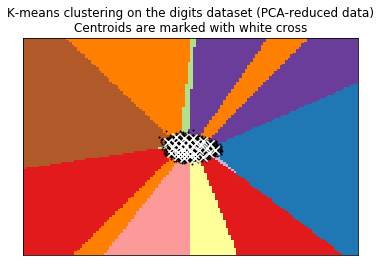

In [53]:
data = investor_embed_mat
num_clusters=30
num_components=2

reduced_data = PCA(n_components=num_components).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=69, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()